In [2]:
import numpy as np
from tools import *
from fitters import *
from plots import *
import seaborn as sns
sns.set_theme()
%load_ext autoreload
%autoreload 2


In [70]:
def test_run(noise=0, beta=0,  dim=12,  Npts=100, start_end=(-6, 6), base_sig=lambda x: np.zeros_like(x), iteration=0):


    time = np.linspace(start_end[0], start_end[1], Npts)
    X_series = base_sig(time) + noise * np.random.randn(Npts)
    # ALGO
    Xhan = build_hankel(X_series, dim)
    X0 = Xhan[:, :-1]
    Xp = Xhan[:, 1:]
    lam = beta * np.eye(dim)

    X0Xp = X0 @ Xp.T
    X0X0 = X0 @ X0.T
    # solve eigenvalue problem
    w, vl = scipy.linalg.eig(
        X0Xp, (X0X0+lam), overwrite_a=True, overwrite_b=True)

    w = np.real(np.real_if_close(w))
    vl = np.real(np.real_if_close(vl))
    theta = vl[:, np.nanargmax(w)]
    w = np.sort(w)[::-1]

    theta /= theta[-1]
    pred_eig = theta @ Xhan

    # X Corr
    X_centered = X_series - X_series.mean()
    XXT = np.outer(X_centered, X_centered.T)
    wXXt = np.sort(scipy.linalg.eig(XXT)[0])[::-1]

    result = {
        'Time': time,
        'X_series': X_series,
        'Pred Eig Left': pred_eig,
        'Top Left Eig Vec': theta,
        'Eig Vals (REAL)': w.real,
        'Eig Vals (IMAG)': w.imag,
        'Spec X@XT': wXXt,
    }

    return result


In [117]:

def zero(x): return np.zeros_like(x)
def sin(x): return np.sin(x)
def sin_es(x): return np.sin(x) + 2*np.cos(x/2) + np.exp(0.01*x)+ 2*np.cos(x/4)+ 0.5*np.cos(x/3)+ 10*np.cos(x/8)


bases = [zero, sin, sin_es]
params = {
    'noise': [1e-4, 1e-1],
    'beta': [0, 1, 10],
    'dim': [10],
    'base_sig': bases,
    'iteration': np.arange(30),
}
results = param_runner(test_run, params)

# for r in results.loc[(results['dim'] == 5) & (results['beta'] == 1e-7) & (results['noise']==0.0001)]['Pred Eig Left']:
#     plt.plot(r)
# plt.show()


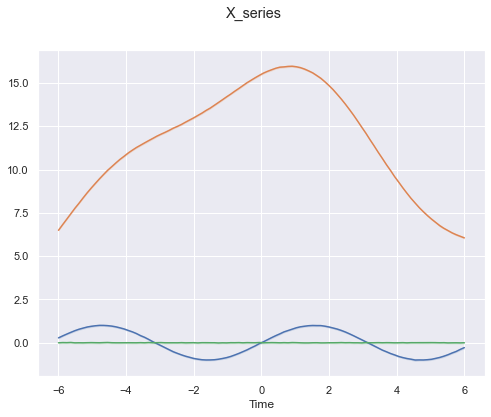

In [118]:
plot_dataframe(results, 'X_series', line_cols=['base_sig'], x_col='Time', aggregate='error', legend=False)

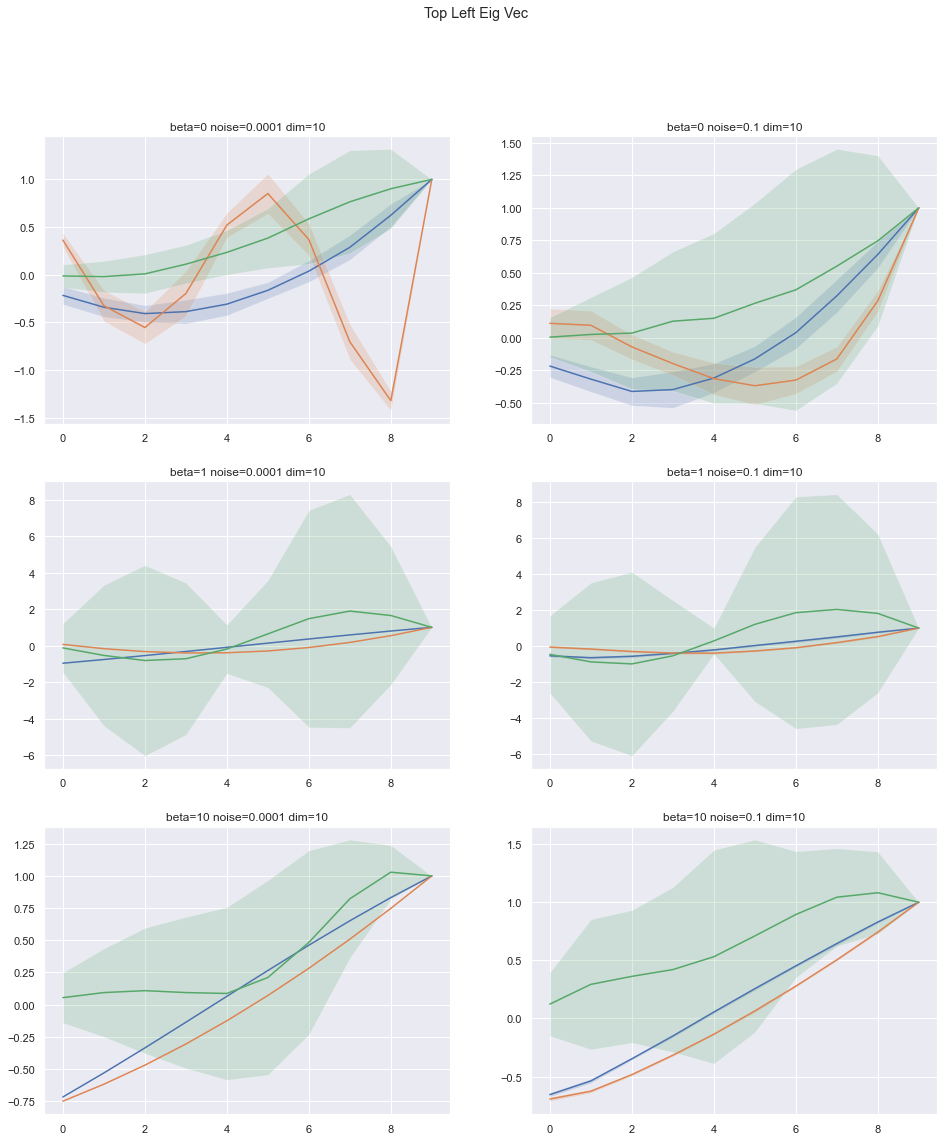

In [119]:
plot_dataframe(results, 'Top Left Eig Vec', line_cols=['base_sig'], title_cols=['beta', 'noise', 'dim'], legend=False)

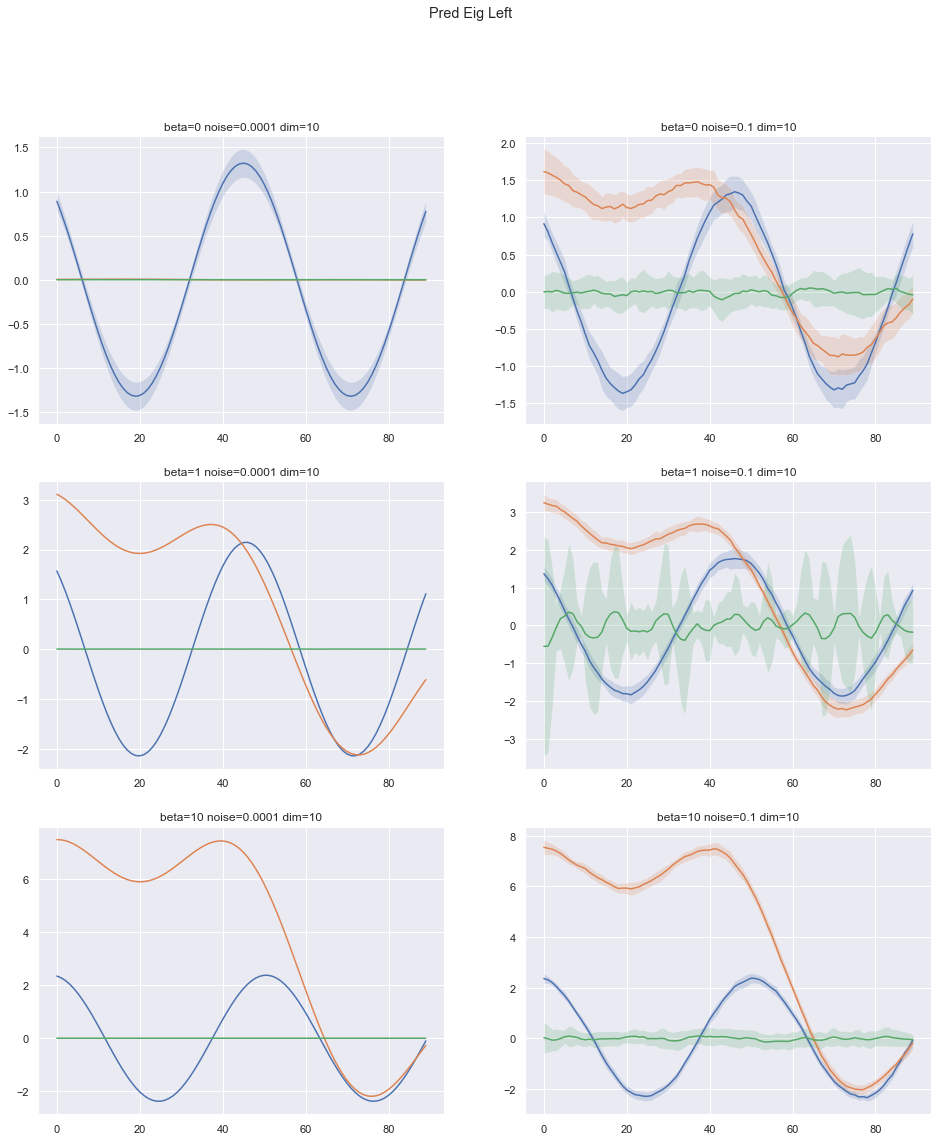

In [120]:
plot_dataframe(results, 'Pred Eig Left', line_cols=['base_sig'], title_cols=['beta', 'noise', 'dim'], legend=False)